In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install spotipy

In [3]:
import sys
import spotipy
import spotipy.util as util

#authorize some stuff and test getting a list of my current saved tracks
import os
os.environ["SPOTIPY_CLIENT_ID"] = '3171b375071e4b4cac38e071125941d6'
os.environ["SPOTIPY_CLIENT_SECRET"] = '888d44a82ea5402fa3222339fc6e916a'
os.environ["SPOTIPY_REDIRECT_URI"] = 'http://localhost/'

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

token = util.prompt_for_user_token(username, scope)

# Print some tracks
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    for item in results['items']:
        track = item['track']
        print(track['name'] + ' - ' + track['artists'][0]['name'])
else:
    print("Can't get token for", username)
    
#Test some stuff using T Swift
urn = 'spotify:artist:06HL4z0CvFAxyc27GXpf02'

sp.trace = False # turn off tracing
sp.trace_out = False # turn off trace out

#artist = sp.artist(urn)
#print(artist)


#user = sp.user('laylaokane')
#print(user)


Nobody Else Will Be There - The National
Day I Die - The National
Walk It Back - The National
The System Only Dreams in Total Darkness - The National
Born to Beg - The National
Turtleneck - The National
Empire Line - The National
I'll Still Destroy You - The National
Guilty Party - The National
Carin at the Liquor Store - The National
Dark Side of the Gym - The National
Sleep Well Beast - The National
Frim Fram Sauce - Diana Krall
Want You Back - HAIM
Bad Blood - Taylor Swift
The Modern Leper - Frightened Rabbit
Bluebird - The Loreleis
Celebrate - Ingrid Michaelson
Hell No - Ingrid Michaelson
Time to Pretend - MGMT


In [4]:
#get categories of playlists
categories = sp.categories(country=None, locale=None, limit=50, offset=0)


In [5]:
#Get the ids of categories
temp = categories['categories']

cat_ids = []
for item in temp['items']:
    cat_ids.append(item['id'])
print(cat_ids)

['toplists', 'holidays', 'chill', 'pop', 'mood', 'hiphop', 'edm_dance', 'party', 'rock', 'workout', 'focus', 'decades', 'dinner', 'sleep', 'indie_alt', 'rnb', 'popculture', 'metal', 'soul', 'romance', 'jazz', 'classical', 'latin', 'country', 'folk_americana', 'blues', 'travel', 'kids', 'reggae', 'gaming', 'punk', 'funk', 'comedy']


In [6]:
#Get playlists for each of the ids of the categories
playlists = {}
for cat_id in cat_ids:
    playlists[cat_id] = sp.category_playlists(category_id=cat_id, country=None, limit=50, offset=0)

# Get playlist ids for each category (will then use this to grab song info)
playlist_ids_by_cat = {}
for category, playlist in playlists.items():
    #print(playlist['playlists']['items'][0]['id'])
    playlist_ids_by_cat[category] = [x['id'] for x in playlist['playlists']['items']]


In [7]:
'''
Useful track-getting functions!
'''

def spotify_id_to_isrc(spotify_ids):
    '''
    converts spotify ids to isrcs
    '''
    tracks = sp.tracks(spotify_ids)
    return [x['external_ids']['isrc']  for x in tracks['tracks']]

def isrc_to_spotify_id(isrcs):
    '''
    converts isrcs to spotify ids
    This takes a while since we need to search
    Is there a better way to get this info?
    Note: isrc --> spotify_id is not necessarily a one-to-one mapping (multiple spotify ids
    can map to the same isrc)
    ''' 
    ids = []
    for isrc in isrcs:
        ids.append(sp.search('isrc:'+isrc)['tracks']['items'][0]['id'])
    return ids

def get_popularity_and_markets(spotify_ids):
    rez = {}
    rez['popularity'] = []
    rez['num_avail_mkts'] =  []
    # only do 50 at a time for API stability
    chunk_size= 42
    for i in range(0, len(spotify_ids), chunk_size):
        chunk = spotify_ids[i:i+chunk_size]
        tracks = sp.tracks(chunk)
        rez['popularity'] = rez['popularity'] +  [x['popularity'] for x in tracks['tracks']]
        rez['num_avail_mkts'] = rez['num_avail_mkts'] + [len(x['available_markets']) for x in tracks['tracks']]
    rez['max_popularity'] = max(rez['popularity'])
    return pd.DataFrame(rez)

def get_followers(playlist_id, user = 'spotify'):
    playlist = sp.user_playlist(user, playlist_id=playlist_id, fields = ['followers'])
    return playlist['followers']['total']

#Default: US, 11/24/2017 at 8PM
def get_featured_playlists(country = 'US', time = '2017-11-24T18:00:00'):
    featured = sp.featured_playlists(country=country, timestamp=time, limit=50, offset=0)
    return [x['id'] for x in featured['playlists']['items']]

def get_track_ids(playlist_id = '37i9dQZF1DX3FNkD0kDpDV'):
    ''' 
    Given a Spotify Playlist ID, returns a list of spotify ids for songs in playlist
    '''
    offset = 0
    playlist = sp.user_playlist_tracks(user = 'spotify', playlist_id = playlist_id, limit = 100)
    ids = [x['track']['id']  for x in playlist['items']]
    # if we hit the limit, need to add more
    while len(ids) / (offset + 100) == 1:
        offset = offset + 100
        playlist = sp.user_playlist_tracks(user = 'spotify', playlist_id = playlist_id, limit = 100, offset = offset)
        ids = ids + [x['track']['id']  for x in playlist['items']]
    return ids

def get_track_audio_features(spotify_ids = get_track_ids()):
    'Given a list of spotify IDs, returns a dataframe of track audio features'
    chunk_size= 42
    tmp = {}
    for i in range(0, len(spotify_ids), chunk_size):
        chunk = spotify_ids[i:i+chunk_size]
        features = sp.audio_features(chunk)
        tmp_df = pd.DataFrame([x for x in features if isinstance(x, dict)])
        tmp.update(tmp_df.to_dict())
    df = pd.DataFrame(tmp)
    df = df.drop(['analysis_url', 'track_href', 'uri', 'type'], 1)
    return df


In [8]:
import time
def get_playlist_data(playlist_ids):
    '''
    Given a list of Spotify playlist IDs, returns a dataframe containing a row
    for each inputed playlist with columns for the following data:
    1) *average* audio characteristics for the songs in that playlist:
        acousticness, danceability, duration,
        energy, instrumentalness, key, liveness, loudness, mode, tempo,
        valence, and time signature
    2) average popularity of songs in the playlist
    3) popularity of most popular song in playlist (might be an anchor song to the playlist)
    4) average # of markets the songs in the playlist are available i
    5) global playlist info
        - number of followers the playlist has (response variable?)
        - number of tracks in playlist
        - whether or not the playlist was "featured" on 11/24/2017 at 8PM
    '''
    rez = {}
    # force list
    if not isinstance(playlist_ids, list):
        playlist_ids = [playlist_ids]
        
    featured_playlists = get_featured_playlists()
    for playlist_id in playlist_ids:
        print('Getting info for: ' + playlist_id)
        tmp = {}
        try:
            track_ids = get_track_ids(playlist_id)
        except spotipy.client.SpotifyException:
            print('WARNING: Playlist does not exist. Skipping.')
            continue
        except:
            time.sleep(10)
            track_ids = get_track_ids(playlist_id)
        # get average audio characteristics
        audio_chars = get_track_audio_features(track_ids).mean().to_dict()
        # get popularity and markets
        pop_and_mkts = get_popularity_and_markets(track_ids).mean().to_dict()
        # get # followers
        tmp['num_followers'] = get_followers(playlist_id)
        tmp['num_tracks'] = len(track_ids)
        tmp['featured'] = 1 if playlist_id in featured_playlists else 0
        tmp.update(audio_chars)
        tmp.update(pop_and_mkts)
        rez[playlist_id] = tmp
    return pd.DataFrame(rez).T

data = {}
for cat, playlists in playlist_ids_by_cat.items():
    print('Starting Category: ' + cat)
    playlist_data = get_playlist_data(playlists)
    playlist_data['category'] = cat
    data.update(playlist_data.T.to_dict())


Starting Category: popculture
Getting info for: 37i9dQZF1DX44t7uCdkV1A
Getting info for: 37i9dQZF1DX1328t2iygZy
Getting info for: 37i9dQZF1DX4JAvHpjipBk
Getting info for: 37i9dQZF1DXa3KA3nCTOQa
Getting info for: 37i9dQZF1DX6R7YjFMxwJB
Getting info for: 2pAubOpmQz0GgwcNZEMnsC
Getting info for: 2NoR0KhNZ8oZnC3HoNt2FV
Getting info for: 37i9dQZF1DWWjGdmeTyeJ6
Getting info for: 37i9dQZF1DWWwaxRea1LWS
Getting info for: 1RMWowofjrgGz9pUrLPHnX
Getting info for: 37i9dQZF1DX50yT1VeARvT
Getting info for: 37i9dQZF1DX5qGup0t1SY0
Getting info for: 37i9dQZF1DX9ZROpgFaLdL
Getting info for: 37i9dQZF1DX2FcXrz51eUF
Getting info for: 37i9dQZF1DX1H32MrlR3uQ
Getting info for: 37i9dQZF1DX8ADx91pud0L
Getting info for: 37i9dQZF1DX0fxvQuCbHMa
Getting info for: 37i9dQZF1DX6QeEMcN5RiG
Getting info for: 37i9dQZF1DWUnlVCphEp2r
Getting info for: 37i9dQZF1DX5h8XoTduzLi
Starting Category: workout
Getting info for: 37i9dQZF1DX76Wlfdnj7AP
Getting info for: 37i9dQZF1DXdxcBWuJkbcy
Getting info for: 37i9dQZF1DWSJHnPb1f0X3


Getting info for: 37i9dQZF1DX65py6HnnlE1
Getting info for: 37i9dQZF1DWVAa4Dwc5f7L
Getting info for: 37i9dQZF1DX8AjME0HhWBt
Getting info for: 37i9dQZF1DX8DSRR3tGze6
Getting info for: 37i9dQZF1DWWMMY2y10lFp
Getting info for: 37i9dQZF1DX6FhkMXKOs07
Getting info for: 37i9dQZF1DWV5sGFwUJeqR
Starting Category: soul
Getting info for: 37i9dQZF1DX6VDO8a6cQME
Getting info for: 37i9dQZF1DX2UgsUIg75Vg
Getting info for: 37i9dQZF1DX62Nfha2yFhL
Getting info for: 37i9dQZF1DWVEvzGeX3eRs
Getting info for: 37i9dQZF1DX5lDysu4GbKR
Getting info for: 37i9dQZF1DWSXWSaQmvWOB
Getting info for: 37i9dQZF1DXcAiMO5AYxE8
Getting info for: 37i9dQZF1DX3KoYiZJ8DD4
Getting info for: 37i9dQZF1DX0H8hDpv38Ju
Getting info for: 37i9dQZF1DWULEW2RfoSCi
Getting info for: 37i9dQZF1DX2Ma8k80RiMN
Getting info for: 37i9dQZF1DX44dZ4p5QLf4
Getting info for: 37i9dQZF1DXea80XwOJRgD
Getting info for: 37i9dQZF1DX4GMJS146m00
Starting Category: indie_alt
Getting info for: 37i9dQZF1DX2Nc3B70tvx0
Getting info for: 37i9dQZF1DXdbXrPNafg9d
Gett

Getting info for: 37i9dQZF1DXc8kgYqQLMfH
Getting info for: 37i9dQZF1DX2TRYkJECvfC
Getting info for: 37i9dQZF1DX504r1DvyvxG
Getting info for: 37i9dQZF1DWVFJtzvDHN4L
Getting info for: 37i9dQZF1DWVIzZt2GAU4X
Getting info for: 37i9dQZF1DX889U0CL85jj
Getting info for: 37i9dQZF1DWYiR2Uqcon0X
Getting info for: 37i9dQZF1DXci7j0DJQgGp
Getting info for: 37i9dQZF1DWVvXA824aCbn
Getting info for: 37i9dQZF1DWZqd5JICZI0u
Getting info for: 37i9dQZF1DXdCsscAsbRNz
Getting info for: 37i9dQZF1DWXi7h4mmmkzD
Getting info for: 37i9dQZF1DX8ymr6UES7vc
Getting info for: 37i9dQZF1DWZ0OzPeadl0h
Getting info for: 37i9dQZF1DX83I5je4W4rP
Getting info for: 37i9dQZF1DX1T2fEo0ROQ2
Getting info for: 37i9dQZF1DX4Q2SnB3glnP
Getting info for: 37i9dQZF1DWXIFKBoyoLJJ
Getting info for: 37i9dQZF1DX1wdZM1FEz79
Getting info for: 37i9dQZF1DWTA0RRFCoIUN
Getting info for: 37i9dQZF1DX32oVqaQE8BM
Getting info for: 37i9dQZF1DXa9xHlDa5fc6
Getting info for: 37i9dQZF1DX571ttkrxAeN
Getting info for: 37i9dQZF1DX5bjCEbRU4SJ
Getting info for

Getting info for: 37i9dQZF1DX3mvx0imueXo
Getting info for: 37i9dQZF1DWYtKpmml7moA
Getting info for: 37i9dQZF1DWW7BONj8RiqI
Getting info for: 37i9dQZF1DX9udeSemCofA
Starting Category: folk_americana
Getting info for: 37i9dQZF1DWYV7OOaGhoH0
Getting info for: 37i9dQZF1DWXJyjYpHunCf
Getting info for: 37i9dQZF1DX9crXQ0wuuXE
Getting info for: 37i9dQZF1DX2taNm7KfjOX
Getting info for: 37i9dQZF1DXaUDcU6KDCj4
Getting info for: 37i9dQZF1DWVl5gPCRkquk
Getting info for: 37i9dQZF1DWV5vqkTng2MA
Getting info for: 37i9dQZF1DXat5j4Lk8UEj
Getting info for: 37i9dQZF1DX2FJ4E5eMYdk
Getting info for: 37i9dQZF1DXaiAJKcabR16
Getting info for: 37i9dQZF1DX3Fzl4v4w9Zp
Getting info for: 37i9dQZF1DWSKpvyAAcaNZ
Getting info for: 37i9dQZF1DX28npkgy2RE4
Getting info for: 37i9dQZF1DX504r1DvyvxG
Getting info for: 37i9dQZF1DXa2HpTqP3clz
Getting info for: 37i9dQZF1DX6dvuioZhoLo
Getting info for: 37i9dQZF1DXcDxnC0UqHJa
Getting info for: 37i9dQZF1DX58NJL8iVBGW
Getting info for: 37i9dQZF1DWSIcimvN18p3
Getting info for: 37i9d

Getting info for: 37i9dQZF1DX5kUFcXez8kt
Getting info for: 37i9dQZF1DX1FuwERxHNIM
Starting Category: rock
Getting info for: 37i9dQZF1DWXRqgorJj26U
Getting info for: 37i9dQZF1DXa6YOhGMjjgx
Getting info for: 37i9dQZF1DWY6vTWIdZ54A
Getting info for: 37i9dQZF1DX8FwnYE6PRvL
Getting info for: 37i9dQZF1DWZn9s1LNKPiM
Getting info for: 37i9dQZF1DX153gOfbCM2i
Getting info for: 37i9dQZF1DX3YMp9n8fkNx
Getting info for: 37i9dQZF1DWWGFQLoP9qlv
Getting info for: 37i9dQZF1DX82Zzp6AKx64
Getting info for: 37i9dQZF1DWSlJG7YPUBHF
Getting info for: 37i9dQZF1DX9wa6XirBPv8
Getting info for: 37i9dQZF1DX11ghcIxjcjE
Getting info for: 37i9dQZF1DWXs1L3AC0Xio
Getting info for: 37i9dQZF1DX0xLQsW8b5Zx
Getting info for: 37i9dQZF1DXd0ZFXhY0CRF
Getting info for: 37i9dQZF1DXdpVGstUksUC
Getting info for: 37i9dQZF1DWSDoVybeQisg
Getting info for: 37i9dQZF1DWZkHEX2YHpDV
Getting info for: 37i9dQZF1DXbDjX0hus3Iu
Getting info for: 37i9dQZF1DX7k3T9O9bscd
Getting info for: 37i9dQZF1DX3YlUroplxjF
Getting info for: 37i9dQZF1DX2S9r

In [2]:
import pickle
#pickle.dump( data, open( "playlist_data.p", "wb" ) )

In [168]:
import pickle
import seaborn as sns
plt.style.use('seaborn')
with open('playlist_data.p', 'rb') as f:
    data = pickle.load(f)
    data = pd.DataFrame(data).T
#split into train / test to avoid cheating
np.random.seed(1234)
train_pct = .5
msk = np.random.uniform(0,1,len(data)) < train_pct
train = data.loc[msk, :]
test = data.loc[~msk, :]

In [169]:
avgs = train.groupby('category').apply(np.mean)

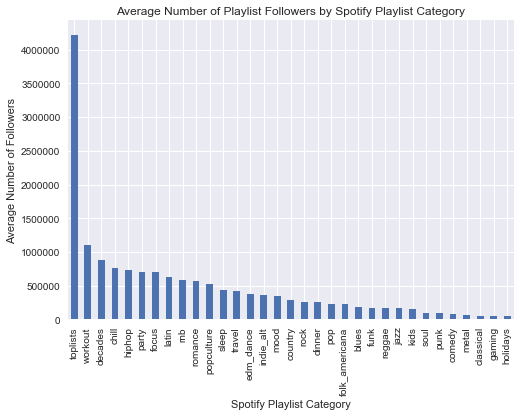

In [207]:
pd.Series(avgs['num_followers']).sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Spotify Playlist Category')
plt.ylabel('Average Number of Followers')
plt.title('Average Number of Playlist Followers by Spotify Playlist Category')

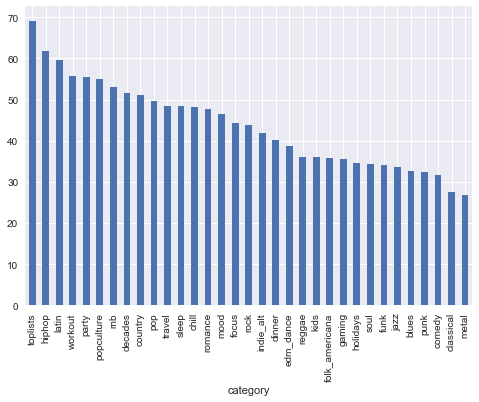

In [171]:
avgs['popularity'].sort_values(ascending = False).plot(kind = 'bar')


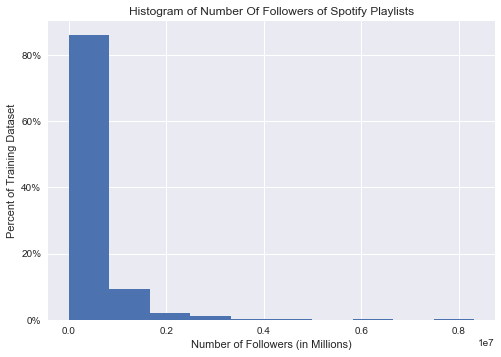

In [185]:
import matplotlib.ticker as tick
ax = train['num_followers'].hist(weights = np.zeros_like(train['num_followers']) + 1. / train['num_followers'].size)
plt.title('Histogram of Number Of Followers of Spotify Playlists')
plt.xlabel('Number of Followers (in Millions)')
plt.ylabel('Percent of Training Dataset')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

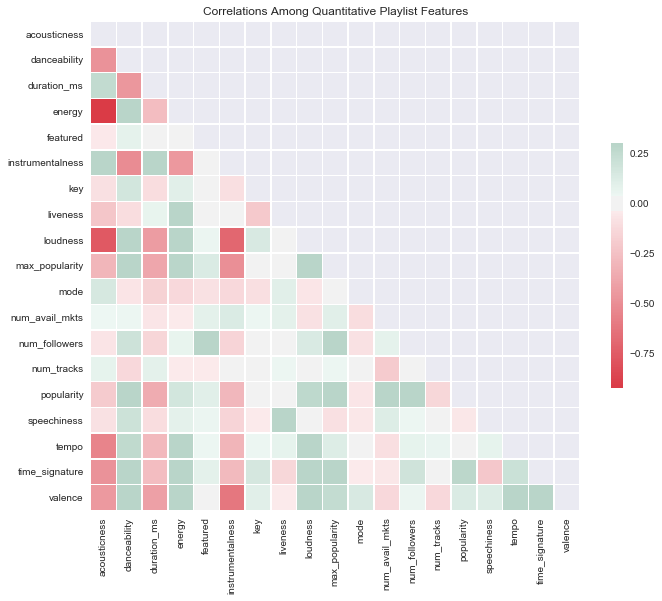

In [204]:
import seaborn as sns
corr = train[[x for x in train.columns if x !='category']].astype(float).corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations Among Quantitative Playlist Features')

In [189]:
import h5py
summary = h5py.File('msd_summary_file.h5', 'r')

In [188]:
Datasetnames=summary.keys()
pd.read_hdf('msd_summary_file.h5')

ValueError: key must be provided when HDF5 file contains multiple datasets.

In [191]:
tmp = pd.Series(summary['metadata']['songs']['song_hotttnesss'], index = summary['metadata']['songs']['genre'])

In [210]:
tagtraum_path = 'msd_beatunes_map.cls\msd_beatunes_map.cls'
tagtraum_dict = {}
with open(tagtraum_path, 'r', encoding="utf8") as t:
    tagtraum_data = t.readlines()
    for line in tagtraum_data:
        d = line.split("\t")
        tagtraum_dict[d[0]] = d[1:]

In [219]:
genres = {}
for key, value in tagtraum_dict.items():
    if value:
        genres[key] = value[0]

In [221]:
pd.Series(genres)

TRAAAAK128F9318786                  Rock
TRAAAAV128F421A322                  Rock
TRAAAAW128F429D538               Hip-Hop
TRAAAAY128F42A73F0                 World
TRAAABD128F429CF47                  Rock
TRAAADJ128F4287B47                  Rock
TRAAADZ128F9348C2E                 Latin
TRAAAEA128F935A30D        Unclassifiable
TRAAAED128E0783FAB                  Jazz
TRAAAEF128F4273421                  Rock
TRAAAEM128F93347B9     Electronica/Dance
TRAAAFD128F92F423A                  Rock
TRAAAFP128F931B4E3               Hip-Hop
TRAAAGF12903CEC202                   Pop
TRAAAGR128F425B14B                   Pop
TRAAAHD128F42635A5                  Rock
TRAAAHJ128F931194C                  Rock
TRAAAHZ128E0799171               Hip-Hop
TRAAAIC128F14A5138                  Rock
TRAAAIR128F1480971                   Pop
TRAAAJN128F428E437            Soundtrack
TRAAAJO12903CAAC69        Easy Listening
TRAAAMQ128F1460CD3               Hip-Hop
TRAAANK128F428B515     Electronica/Dance
TRAAAQN128F9353B